# MlFlow

## limpar arquivos do mlflow


In [12]:
# não funcionou
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

for exp in client.search_experiments(view_type=ViewType.ALL):
    deleted_runs = client.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="",  # não filtra por status aqui
        run_view_type=ViewType.DELETED_ONLY,  # ← chave
        max_results=1000,
    )
    print(f"{exp.name} (ID: {exp.experiment_id}) → {len(deleted_runs)} runs marcadas como deleted")
        

# mlflow gc `
#   --backend-store-uri "file:///D:/Documentos/OneDrive/Documentos/Mestrado/mlruns" `
#   --artifacts-destination "file:///D:/Documentos/OneDrive/Documentos/Mestrado/mlartifacts" `
#   --older-than 1d

D-ESRGAN (ID: 838611645833230282) → 4 runs marcadas como deleted
D-SRGAN (ID: 818644383752493905) → 0 runs marcadas como deleted
ESRGAN_DEM (ID: 908603184323111774) → 143 runs marcadas como deleted
ESRGAN_DEM_FineTuning (ID: 731508295212507843) → 201 runs marcadas como deleted
lightning_logs (ID: 581968852766782379) → 2 runs marcadas como deleted
ESRGAN (ID: 673066277191768695) → 41 runs marcadas como deleted
PSNR_ESRGAN (ID: 405553253288596720) → 114 runs marcadas como deleted
batch_32_My_Model (ID: 347577080585807910) → 17 runs marcadas como deleted
batch_32_MeuModelo_1 (salvando toda as métricas) (ID: 532099041450573728) → 17 runs marcadas como deleted
batch_32 (ID: 829229874360175037) → 8 runs marcadas como deleted
Default (ID: 0) → 108 runs marcadas como deleted


## adicionar um parâmetro após a conclusão

In [1]:
from mlflow.tracking import MlflowClient
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
client.log_param(run_id="63a9f25573fa4f498c4290641023d4c7", key="alfa_slope", value=0)

0

## baixar imagens de teste e unir elas para comparação de diferentes runs

In [ ]:
import argparse
import io
import os
import sys
import shutil
import tempfile
from pathlib import Path
from typing import Dict, Iterable, List, Tuple, Optional
from PIL import Image, ImageDraw, ImageFont, ImageChops
import mlflow


def _download_artifact_dir(run_id: str, subdir: str,
            dst_root: Path, tracking_uri: str = "http://127.0.0.1:5000" ) -> Path:
    """
    Baixa recursivamente 'subdir' (ex.: 'test_imgs') de uma run para 'dst_root/run_id/subdir'.
    Usa o esquema 'runs:/<run_id>/<subdir>' para ser robusto ao backend do MLflow.
    """
    mlflow.set_tracking_uri(tracking_uri)
    artifact_uri = f"runs:/{run_id}/{subdir.strip('/')}"
    local_dir = dst_root / run_id / subdir
    local_dir.parent.mkdir(parents=True, exist_ok=True)
    # baixa tudo para uma pasta temporária e então move
    tmp_dir = Path(mlflow.artifacts.download_artifacts(artifact_uri))  # type: ignore
    if local_dir.exists():
        shutil.rmtree(local_dir)
    shutil.copytree(tmp_dir, local_dir)
    return local_dir

def _gather_images(root: Path) -> Dict[str, Path]:
    """
    Varrre root recursivamente e retorna dict {basename_sem_ext: caminho_arquivo}.
    Se houver nomes repetidos, o último encontrado prevalece.
    """
    exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff")
    out: Dict[str, Path] = {}
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            key = p.stem  # basename sem extensão
            out[key] = p
    return out

def _filter_pairs_by_select(pairs: List[Tuple[str, Path, Path]],
            select: Optional[str]) -> List[Tuple[str, Path, Path]]:
    if not select:
        return pairs
    s = select.lower()
    return [(k, pa, pb) for (k, pa, pb) in pairs if s in k.lower()]

def _draw_label(img: Image.Image, text: str, margin: int = 20) -> Image.Image:
    """
    Adiciona uma faixa superior com o texto (nome da run/arquivo).
    """
    # tentar achar uma fonte razoável; se falhar, usa padrão
    try:
        # Arial/DejaVu podem não existir em todos os ambientes
        font = ImageFont.truetype("arial.ttf", size=80)
    except Exception:
        try:
            font = ImageFont.truetype("DejaVuSans.ttf", size=80)
        except Exception:
            font = ImageFont.load_default()

    draw = ImageDraw.Draw(img)
    bbox = draw.textbbox((0, 0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    pad = margin
    # cria nova imagem para a faixa
    bar_h = th + 2 * pad
    bar = Image.new("RGB", (img.width, bar_h), (32, 32, 32))
    draw_bar = ImageDraw.Draw(bar)
    draw_bar.text((img.width//2, pad), text, fill=(255, 255, 255), font=font, align='center')
    out = Image.new("RGB", (img.width, img.height + bar_h), (0, 0, 0))
    out.paste(bar, (0, 0))
    out.paste(img, (0, bar_h))
    return out

def _stack_vertical(a: Image.Image, b: Image.Image, label_a: str, label_b: str, pad: int = 8) -> Image.Image:
    """
    Monta painel em coluna (A em cima, B embaixo), alinhando larguras e adicionando labels.
    """
    # 1) Ajuste para mesma largura (sem distorcer): centraliza em canvas W
    W = max(a.width, b.width)

    def pad_to_w(img: Image.Image, W: int) -> Image.Image:
        if img.width == W:
            return img
        canvas = Image.new("RGB", (W, img.height), (0, 0, 0))
        left = (W - img.width) // 2
        canvas.paste(img, (left, 0))
        return canvas

    a2 = pad_to_w(a, W)
    b2 = pad_to_w(b, W)

    # 2) Labels individuais
    panel_a = _draw_label(a2, label_a).convert("RGB")
    panel_b = _draw_label(b2, label_b).convert("RGB")

    # 3) Reajusta largura após labels (caso fonte/medidas mudem)
    W = max(panel_a.width, panel_b.width)

    def padW(img: Image.Image, W: int) -> Image.Image:
        if img.width == W:
            return img
        c = Image.new("RGB", (W, img.height), (0, 0, 0))
        left = (W - img.width) // 2
        c.paste(img, (left, 0))
        return c

    panel_a = padW(panel_a, W)
    panel_b = padW(panel_b, W)

    # 4) Empilha verticalmente com espaçamento
    H = panel_a.height + pad + panel_b.height
    out = Image.new("RGB", (W, H), (0, 0, 0))
    out.paste(panel_a, (0, 0))
    out.paste(panel_b, (0, panel_a.height + pad))
    return out

def trim_whitespace(img: Image.Image, bg=(255, 255, 255), tol=6) -> Image.Image:
    """Remove bordas quase brancas (com tolerância)."""
    bg_img = Image.new(img.mode, img.size, bg)
    # diferença entre a imagem e um fundo branco
    diff = ImageChops.difference(img, bg_img)
    # aumenta contraste e aplica “offset” negativo para tolerar antialias
    diff = ImageChops.add(diff, diff, scale=2.0, offset=-tol)
    bbox = diff.getbbox()
    return img.crop(bbox) if bbox else img

In [23]:
#Download das imagens. só mudar o run_id do que quiser ser baixado
dst_root = Path(r'C:\Users\Eduardo JR\Fast\SRIU\Imgs')
subdir = 'test_imgs'
# Generator 10 RRDB
run_id_1 = 'dd5b7044eea0412d940ef9c84abd9382'
dir1 = _download_artifact_dir(run_id_1, subdir, dst_root)

#ESRGAN 10 RRDB
# run_id_2 = '600983e09c1044f7972ecdfefa62461b'
#Generator 23 RRDB
run_id_2 = 'd1fbf6f9db75401e9620c2ddbd06ff73'
dir2 = _download_artifact_dir(run_id_2, subdir, dst_root)


In [24]:
A = _gather_images(dir1)
B = _gather_images(dir2)
out_dir = Path(dst_root) / f"{run_id_1}_vs_{run_id_2}"
out_panels_dir = out_dir / "panels"
out_panels_dir.mkdir(parents=True, exist_ok=True)
keys = sorted(set(A.keys()) & set(B.keys()))
pairs = [(k, A[k], B[k]) for k in keys]
for key, img_a, img_b in pairs:
    img_a = Image.open(img_a).convert('RGB')
    img_b = Image.open(img_b).convert('RGB')
    w, h = img_a.size
    
    #corto o título orginal
    img_a = img_a.crop((0, 100, w, h))
    img_b = img_b.crop((0, 100, w, h))
    img_a = trim_whitespace(img_a, bg=(255, 255, 255))
    img_b = trim_whitespace(img_b, bg=(255, 255, 255))
    stack = _stack_vertical(img_a, img_b, f'Generator 10RRDB - {key}', f'Generator 23 RRDB- {key}')
    stack.save(out_panels_dir / f"{key}_panel.png")


# Preparo

## GEE

In [ ]:
# usado para gerar as coordenadas para exportar as imagens COP e SRTM do GEE
# não to conseguindo autenticar aqui, pega as coordenadas e copia no GEE.

import geopandas as gpd
from shapely.ops import unary_union
bd_path = r"C:\Users\Eduardo JR\Fast\SRIU\bd_srmde.gpkg"
region = gpd.read_file(bd_path, layer='esrgan_finetuning')
# print(region)
region_merged = unary_union(region.geometry)
geojson_geometry = region_merged.__geo_interface__
txt = str(geojson_geometry['coordinates'])
txt2=txt.replace('(', '[').replace(')', ']')
print(txt2)


## Teste PSNR

In [ ]:
"""A ideia era calcular o PSNR entre os MI para ver se dava pra ver se da pra diferenciar entre regiões de desmatamento e não desmatamento.
em alguns casos extremos sim, mas deixa passar muita coisa. não vi áreas sem desmatamento com PSNR menor que 50 mas eu vi áreas com desmatamento com o 
PSNR maior que 50, algumas com quase 60 inclusive.
"""
import geopandas as gpd
import rasterio
from pathlib import Path
from shapely.geometry import box
from rasterio.transform import rowcol
import piq
import torch
from rasterio.enums import Resampling
import numpy as np


root_path_sriu = Path(r"C:\Users\Eduardo JR\Fast\SRIU")
root_path_mestrado = Path(r'D:\Documentos\OneDrive\Documentos\Mestrado\Dados')
proj_ram = gpd.read_file(root_path_mestrado /'BD_mestrado.gpkg', layer='Proj_RAM')

ds_ram = rasterio.open(root_path_sriu / "ram_finetuning_15m.tif")
ds_ram_array = torch.from_numpy(ds_ram.read(1)).unsqueeze(0).unsqueeze(0)
ram_nodata_mask = ~ds_ram.dataset_mask()
mask_t = torch.from_numpy(ram_nodata_mask).unsqueeze(0).unsqueeze(0).to(torch.bool)
fill_value = -10

ds_cop = rasterio.open(root_path_sriu / "COP_finetuning_al.tif")
ds_cop_resampled = ds_cop.read(
    out_shape=(
        ds_cop.count,
        int(ds_cop.height * 2),
        int(ds_cop.width * 2)),
    resampling=Resampling.bilinear)
ds_cop_array = torch.from_numpy(ds_cop_resampled).unsqueeze(0)

ds_srtm = rasterio.open(root_path_sriu / "SRTM_finetuning_al.tif")
ds_srtm_resampled = ds_srtm.read(
    out_shape=(
        ds_srtm.count,
        int(ds_srtm.height * 2),
        int(ds_srtm.width * 2)),
    resampling=Resampling.bilinear)
ds_srtm_array = torch.from_numpy(ds_srtm_resampled).unsqueeze(0)
max_value = max(ds_cop_array.max(),ds_srtm_array.max(), ds_ram_array.max())

left, bottom, right, top = ds_cop.bounds
raster_bbox = box(left, bottom, right, top)

proj_ram_intersect = proj_ram[proj_ram.geometry.intersects(raster_bbox)].copy()
proj_ram_intersect['psnr_srtm_ram'] = np.nan
proj_ram_intersect['psnr_cop_ram'] = np.nan
proj_ram_intersect['psnr_srtm_cop'] = np.nan

for idx, mi in proj_ram_intersect.iterrows():
    minx, miny, maxx, maxy =mi.geometry.bounds
    row0, col0 = rowcol(ds_ram.transform, minx, maxy)  # canto superior-esq
    row1, col1 = rowcol(ds_ram.transform, maxx, miny)  # canto inferior-dir
    
    row_start, row_stop = sorted((row0, row1))
    col_start, col_stop = sorted((col0, col1))
    if row_stop> ds_ram.height:
        continue
    
    mask_mi = mask_t[:,:,row_start:row_stop, col_start:col_stop]
    cop_mi = ds_cop_array[:,:,row_start:row_stop, col_start:col_stop]
    cop_mi.masked_fill_(mask_mi, fill_value)
    srtm_mi = ds_srtm_array[:,:,row_start:row_stop, col_start:col_stop]
    srtm_mi.masked_fill_(mask_mi, fill_value)
    ram_mi = ds_ram_array[:,:,row_start:row_stop, col_start:col_stop]
    ram_mi.masked_fill_(mask_mi, fill_value)
    try:
        psnr_1 = piq.psnr(cop_mi,srtm_mi,data_range=max_value).item()
        
    except:
        psnr_1 = 0
    try:
        psnr_2 = piq.psnr(ram_mi,srtm_mi,data_range=max_value).item()
        
    except:
        psnr_2 = 0
    
    try:
        psnr_3 = piq.psnr(cop_mi,ram_mi,data_range=max_value).item()
        
    except:
        psnr_3 = 0
        
    proj_ram_intersect.loc[idx, 'psnr_srtm_ram'] = psnr_2
    proj_ram_intersect.loc[idx, 'psnr_cop_ram'] = psnr_3
    proj_ram_intersect.loc[idx, 'psnr_srtm_cop'] = psnr_1

# proj_ram_intersect.to_file(
#     filename = root_path_sriu/'bd_srmde.gpkg',
#     driver   = "GPKG",
#     layer    = "psnr_test_nodata",
# )

## Calculo de média e desvio padrão dos Dataset DIV2K e Flicker em Grayscale

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import v2
import torch
import os


class DS_div2_flickr_gray(Dataset):
    def __init__(self,
                 dataset_file: str,
                 root_dir:str,
                 transform):
        super().__init__()
        self.dataset_file = dataset_file
        self.root_dir = root_dir
        self.transform = transform
        self.image_pairs = []
        
        # Read image pairs from text file and store in hr_path, lr_path
        with open(self.dataset_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:  # Skip empty lines
                    hr_path, lr_path = [x.strip() for x in line.split(',')]
                    self.image_pairs.append((hr_path, lr_path))
    def __len__(self):
        return len(self.image_pairs)

        
    def __getitem__(self, idx):
        hr_path, lr_path = self.image_pairs[idx]
        
        lr_image = Image.open(os.path.join(self.root_dir,lr_path)).convert('L') #L
        
        if self.transform:
            lr_image = self.transform(lr_image).to('cuda')
            
        
        return lr_image.shape
        

tranforms = v2.Compose([v2.ToImage(), 
                       v2.ToDtype(torch.float32, scale=True),
                    #    v2.Resize([1000,1000])
                    ])

DIV2K_dataset = DS_div2_flickr_gray(dataset_file=r'D:\Documentos\OneDrive\Documentos\Mestrado\Super Resolução Imagem Única\SRIU\datasets\train_DIV2K_pair.txt', 
                                root_dir=r"C:\Users\Eduardo JR\Fast",
                                transform=tranforms)

DIV2K_dataloader = DataLoader(dataset=DIV2K_dataset,
                        batch_size = 400,
                        # num_workers=4
                        )
DIV2K_samples = []
print('========  DIV2K ========')
for idx, batch  in enumerate(DIV2K_dataloader):
    lr_img = batch
    # std, mean = torch.std_mean(lr_img,1)
    # print(f'batch {idx} media {mean:.4f} e std {std:.4f}')
    DIV2K_samples.append(lr_img)

DIV2K_samples = torch.stack(DIV2K_samples)
# std_fli, mean_fli = torch.std_mean(DIV2K_samples, 1)
# print(f'media {mean_fli:.4f} e std {std_fli:.4f} do conjunto global')
print(DIV2K_samples.min())


# Flickr_dataset = DS_div2_flickr_gray(dataset_file=r'D:\Documentos\OneDrive\Documentos\Mestrado\Super Resolução Imagem Única\SRIU\datasets\train_Flickr_pair.txt', 
#                                 root_dir=r"C:\Users\Eduardo JR\Fast",
#                                 transform=tranforms)

# Flickr_dataloader = DataLoader(dataset=Flickr_dataset,
#                         batch_size = 265,
#                         # num_workers=4
#                         )
# Flickr_samples = []
# print('========  Flickr ========')
# for idx2, batch  in enumerate(Flickr_dataloader):
#     lr_img = batch
#     std, mean = torch.std_mean(lr_img)
#     print(f'batch {idx2} media {mean:.4f} e std {std:.4f}')
#     Flickr_samples.append(lr_img)

# Flickr_samples = torch.stack(Flickr_samples)
# std_fli, mean_fli = torch.std_mean(Flickr_samples, 1)
# print(f'media {mean_fli:.4f} e std {std_fli:.4f} do conjunto global')

# DIV2K_samples=DIV2K_samples.reshape(-1,3,1000,1000)
# Flickr_samples=Flickr_samples.reshape(-1,3,1000,1000)

# DIV2K_Flickr_samples = torch.concat([Flickr_samples, DIV2K_samples],0)
# print('========  DIV2K_Flickr ========')

# # Flickr_samples = torch.stack(Flickr_samples)
# std_fli, mean_fli = torch.std_mean(DIV2K_Flickr_samples, 1)
# print(f'media {mean_fli:.4f} e std {std_fli:.4f} do conjunto global')

# RAM

## Teste Dtype

In [ ]:
import os
from osgeo import gdal

diretorio = r"D:\RAM"

# Lista para armazenar os arquivos encontrados
arquivos_tif = []

# Percorre todos os arquivos e subpastas
for pasta_raiz, _, arquivos in os.walk(diretorio):
    for arquivo in arquivos:
        # Verifica se o arquivo é .tif
        if arquivo.lower().endswith('.tif'):
            caminho_completo = os.path.join(pasta_raiz, arquivo)
            arquivos_tif.append(caminho_completo)


for arquivo in arquivos_tif:
    ds = gdal.Open(arquivo, gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    if arr.dtype != 'float32':
        print(f'o arquivo {arquivo.split('\\')[-1]} está com o tipo {arr.dtype}')

## correção de valor de Nodata

In [ ]:
# verificar pixel NaN
from osgeo import gdal
import numpy as np
ram_path = r"C:\Users\Eduardo JR\Fast\SRIU\ram_finetuning_15m.tif"

ds = gdal.Open(ram_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray().astype(np.float32)

no_data_value = band.GetNoDataValue()  # Pode ser None se não definido
print(no_data_value)

# Verifica NaN, Inf e NoData
has_nan = np.isnan(arr).any()
has_inf = np.isinf(arr).any()
has_no_data = (arr == no_data_value).any() if no_data_value is not None else False

# Resultados
print("=== Teste de Valores Inválidos ===")
print(f"Contém NaN: {has_nan}")
print(f"Contém Inf: {has_inf}")
print(f"Contém NoData: {has_no_data}")

# Contagem de pixels inválidos (opcional)
print(str(len(arr)) + " pixels na imagem")
if has_nan:
    print(f"Total de pixels NaN: {np.isnan(arr).sum()} pixels  - {np.isnan(arr).sum()/len(arr)}%")
if has_inf:
    print(f"Total de pixels Inf: {np.isinf(arr).sum()}")
if has_no_data:
    print(f"Total de pixels NoData: {(arr == no_data_value).sum()} - {(arr == no_data_value).sum()/len(arr)}")

# Fecha o dataset
ds = None

In [ ]:
from osgeo import gdal
import numpy as np

input_path  = r"D:\RAM\Bloco_2\mds\6970w0001s_xband_dsm_32-bit.tif"
output_path = r"D:\RAM\Bloco_2\mds\6970w0001s_xband_dsm_32-bit_novo.tif"

# Abre o raster
ds = gdal.Open(input_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray().astype(np.float32)

# Mascara valores < 1
nodata_val = -9999
mask = arr < 1
arr[mask] = nodata_val

# Cria novo arquivo
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(
    output_path,
    ds.RasterXSize,
    ds.RasterYSize,
    1,
    band.DataType,
    options=["COMPRESS=LZW"]
)
out_ds.SetGeoTransform(ds.GetGeoTransform())
out_ds.SetProjection(ds.GetProjection())

out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(arr)
out_band.SetNoDataValue(nodata_val)

# Fecha arquivos
out_band.FlushCache()
out_ds = None
ds = None

print(f"Gerado: {output_path}")

# testes aleatórios

## criou os ds de treino, val e teste

In [65]:
from torchgeo.datasets import random_bbox_assignment, VectorDataset, BoundingBox, GeoDataset
import geopandas as gpd
from rtree import index as rtree_index
import torch
import numpy as np
from shapely.geometry import mapping
import rasterio
import rasterio.features
from typing import Any

root_path = r"C:\Users\Eduardo JR\Fast\SRIU\\"
region = gpd.read_file(root_path+'bd_srmde.gpkg', layer='esrgan_finetuning_50k')

class VectorDataset_GDF(VectorDataset):
    def __init__(self, path, layer, res=0.0001,  crs=None):
        GeoDataset.__init__(self, transforms=None)
        self.gdf = gpd.read_file(path, layer=layer)
        self.crs = crs or self.gdf.crs
        self.res = res

        # monta um R-tree 3D (x, y, t)
        prop = rtree_index.Property()
        prop.dimension = 3
        self.index = rtree_index.Index(properties=prop)

        for i, geom in enumerate(self.gdf.geometry):
            minx, miny, maxx, maxy = geom.bounds
            # para t usamos 0…0
            coords3d = (minx, miny, 0, maxx, maxy, 0)
            self.index.insert(i, coords3d, obj=i)
            
    @property
    def bounds(self) -> BoundingBox:
        minx, miny, maxx, maxy = self.gdf.total_bounds
        # mint e maxt são temporais. Como não estamos usando tempo, definimos como 0
        return BoundingBox(minx=minx, maxx=maxx, miny=miny, maxy=maxy, mint=0, maxt=0)

    def __getitem__(self, query: BoundingBox) -> dict[str, Any]:
        # recupera índices das geometrias que intersectam a janela
        hits = list(self.index.intersection((query.minx, query.miny,
                                              query.maxx, query.maxy,
                                              query.mint, query.maxt),
                                             objects=True))
        if not hits:
            # retorna máscara vazia
            h = round((query.maxy - query.miny) / self.res)
            w = round((query.maxx - query.minx) / self.res)
            mask = torch.zeros((1, h, w), dtype=torch.uint8)
            return {'aoi': mask, 'crs': self.crs, 'bounds': query}

        shapes = []
        for hit in hits:
            idx = hit.object
            geom = self.gdf.geometry.iloc[idx]
            props =  1 #self.gdf.iloc[idx][self.label_name]
            # converte shapely → geojson para rasterio
            # geojson = mapping(geom.to_crs(self.crs)) todas as entradas estão no mesmo CRS
            geojson = mapping(geom)
            shapes.append((geojson, props))

        # rasterização
        height = round((query.maxy - query.miny) / self.res)
        width  = round((query.maxx - query.minx) / self.res)
        transform = rasterio.transform.from_bounds(
            query.minx, query.miny, query.maxx, query.maxy,
            width, height
        )
        mask = rasterio.features.rasterize(
            shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype=np.uint8
        )
        mask = torch.from_numpy(mask).unsqueeze(0)

        return {'aoi': mask, 'crs': self.crs, 'bounds': query}
    
vector_dataset = VectorDataset_GDF(
    path='C:\\Users\\Eduardo JR\\Fast\\SRIU\\bd_srmde.gpkg',  # Caminho para o arquivo GPKG
    layer='esrgan_finetuning_50k',  # Nome da camada
    crs="EPSG:4326",   # Sistema de coordenadas (WGS84 lat/lon, ajuste se necessário)
)


train, val, test = random_bbox_assignment(vector_dataset, [0.6, 0.2, 0.2])

hits = list(train.index.intersection(
        train.index.bounds, objects=True
    ))
geoms = [box(hit.bbox[0],hit.bbox[1], hit.bbox[3],hit.bbox[4]) for hit in hits]
    # Cria um GeoDataFrame temporário para plot
gdf = gpd.GeoDataFrame(geometry=geoms, crs=train.crs)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, facecolor="lightgray")

Converting VectorDataset_GDF res from 0.0 to 0.0001


NameError: name 'box' is not defined

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import box
def plot_vector_split(split_dataset, ax=None, edgecolor="red", facecolor="none", label=None,
                           save_path = r"C:\Users\Eduardo JR\Fast\SRIU\bd_srmde.gpkg" ,layer_name = None ):
    """
    Plota as geometrias contidas no índice R-tree de um VectorDataset_GDF.
    
    Parâmetros
    ----------
    split_dataset : VectorDataset_GDF
        Instância gerada por random_bbox_assignment.
    ax : matplotlib.axes.Axes, opcional
        Eixo onde desenhar. Se None, cria novo figure+axes.
    edgecolor : str, opcional
        Cor da borda dos polígonos.
    facecolor : str, opcional
        Cor de preenchimento (use "none" para apenas contorno).
    label : str, opcional
        Rótulo para legenda.
        
    Retorna
    -------
    matplotlib.axes.Axes
        Eixo com o plot.
    """
    # Obtém todos os itens do índice
    hits = list(split_dataset.index.intersection(
        split_dataset.index.bounds, objects=True
    ))
    # Extrai somente as geometrias (objetos shapely)
    geoms = [box(hit.bbox[0],hit.bbox[1], hit.bbox[3],hit.bbox[4]) for hit in hits]
    # Cria um GeoDataFrame temporário para plot
    gdf = gpd.GeoDataFrame(geometry=geoms, crs=split_dataset.crs)
    gdf.to_file(save_path, layer=layer_name, driver="GPKG")
    
    
    # Desenha
    gdf.plot(ax=ax, edgecolor=edgecolor, facecolor=facecolor, label=label, linewidth=1)
    return ax


fig, ax = plt.subplots(figsize=(10, 10))
# # plota a região completa em cinza claro
# region.boundary.plot(ax=ax, facecolor="lightgray", edgecolor="none" )

# sobrepõe cada split com cores distintas
plot_vector_split(train, ax=ax, facecolor="blue",   label="Train", layer_name = 'esrgan_finetuning_50k_train')
plot_vector_split(val,   ax=ax, facecolor="green",  label="Val", layer_name = 'esrgan_finetuning_50k_val')
plot_vector_split(test,  ax=ax, facecolor="red",    label="Test", layer_name = 'esrgan_finetuning_50k_test')


# ax.legend()
plt.show()


## plot terrain features

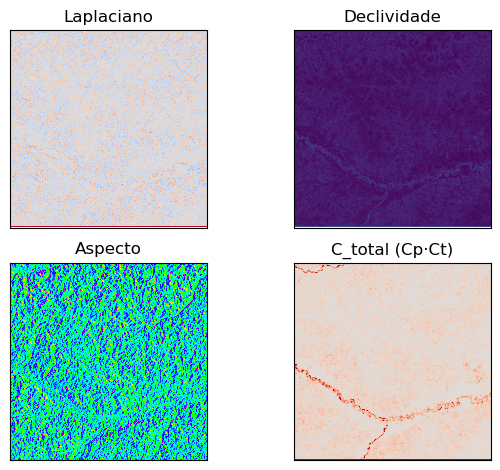

In [9]:
from torchgeo_modules import *
from torchgeo.samplers import RandomGeoSampler
import sys
import os
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
from scripts.terrain_features import Slope, Aspect, CurvatureTotal, Curvature
import matplotlib.pyplot as plt


def plot_func_terreno():
    input_ds = 'COP' #SRTM
    input_ds_path = f"C:/Users/Eduardo JR/Fast/SRIU/{input_ds}_finetuning_al.tif"
    input_ds = InMemoryGeoRaster(input_ds_path)
    input_ds_dict = input_ds.__getitem__(input_ds.bounds)

    sampler = RandomGeoSampler(
                        input_ds,
                        size=1024)

    bbox = next(iter(sampler))
    mopa = input_ds.__getitem__(bbox)
    aspecto = Aspect()
    curvatura = Curvature(30)
    declividade = Slope()
    curv_total = CurvatureTotal(30)

    def imshow_div(ax, arr, pct=99.0):
        a = arr[0]
        lo, hi = np.nanpercentile(a, 100-pct, axis=None), np.nanpercentile(a, pct, axis=None)
        m = max(abs(lo), abs(hi))
        ax.imshow(a, cmap='coolwarm', vmin=-m, vmax=+m)
        ax.set_xticks([]); ax.set_yticks([])
    
    mopa_dec = declividade(mopa['image']).detach().numpy()
    mopa_asp = aspecto(mopa['image']).detach().numpy()
    mopa_cur = curvatura(mopa['image']).detach().numpy()
    mopa_cur_total = curv_total(mopa['image']).detach().numpy()
    
    fig, ax = plt.subplots(2,2)
    imshow_div(ax[0,0], mopa_cur, 90)          # Laplaciano
    ax[0,0].set_title('Laplaciano')
    ax[0,1].imshow(mopa_dec[0], cmap='viridis'); ax[0,1].set_title('Declividade')
    ax[0,1].set_xticks([]); ax[0,1].set_yticks([])
    ax[1,0].imshow(mopa_asp[0], cmap='hsv'); ax[1,0].set_title('Aspecto')
    ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
    imshow_div(ax[1,1], mopa_cur_total, 98)      
    ax[1,1].set_title('C_total (Cp·Ct)')
    plt.tight_layout(); plt.pause(1)
    
    return [mopa_dec, mopa_asp, mopa_cur, mopa_cur_total ]

terrain_features = plot_func_terreno()

In [14]:
terrain_features[1].max(), terrain_features[1].min() 

(359.99866, 0.0)

## calculo sumário de MSE entre COP e RAM

In [1]:
from ESRGAN_DEM import lista_tifs
from torchgeo_modules import DEMDataset,CustomDEMDataset, VectorDataset_GDF, StrictGridGeoSampler
from torchgeo.samplers import RandomGeoSampler
from modules import custom_collate_fn
from torch.utils.data import DataLoader
import geopandas as gpd

input_directory = f"C:\\Users\\Eduardo JR\\Fast\\SRIU\\zoom_4"



input_train = DEMDataset(paths=lista_tifs(input_directory+'/train', 'cop*.tif'))
input_val = DEMDataset(paths=lista_tifs(input_directory+'/val', 'cop*.tif'))
input_test = DEMDataset(paths=lista_tifs(input_directory+'/test', 'cop*.tif'))


ram_train = DEMDataset(paths=lista_tifs(input_directory+'/train', 'ram_*_dsm.tif'))    
ram_val = DEMDataset(paths=lista_tifs(input_directory+'/val', 'ram_*_dsm.tif'))
ram_test = DEMDataset(paths=lista_tifs(input_directory+'/test', 'ram_*_dsm.tif'))

train_aoi = VectorDataset_GDF(
                path='C:\\Users\\Eduardo JR\\Fast\\SRIU\\bd_srmde.gpkg', 
                layer='esrgan_finetuning_50k_train', 
                crs="EPSG:4326")

val_aoi = VectorDataset_GDF(
                path='C:\\Users\\Eduardo JR\\Fast\\SRIU\\bd_srmde.gpkg', 
                layer='esrgan_finetuning_50k_val', 
                crs="EPSG:4326")
test_aoi = VectorDataset_GDF(
                path='C:\\Users\\Eduardo JR\\Fast\\SRIU\\bd_srmde.gpkg', 
                layer='esrgan_finetuning_50k_test', 
                crs="EPSG:4326")


train_ds = CustomDEMDataset(input_train|input_val|input_test, ram_train|ram_val|ram_test)
test_ds = CustomDEMDataset(input_test, ram_test)


# train_sampler = RandomGeoSampler(
#                     train_ds,
#                     size=128,
#                     roi=train_aoi.bounds)
# val_sampler = StrictGridGeoSampler(
#                 dataset=val_ds,
#                 size=128,
#                 stride=128,
#                 roi=val_ds.bounds,
#                 cover= val_aoi)

train_sampler = StrictGridGeoSampler(
                dataset=train_ds,
                size=128,
                stride=128,
                roi=train_ds.bounds,
                cover= train_aoi)

train_dataload = DataLoader(dataset=train_ds, 
                              batch_size=10, 
                              sampler=train_sampler,
                            #   generator= seed,
                              pin_memory=False,
                            #   persistent_workers=True,
                              num_workers= 0,
                              collate_fn=custom_collate_fn)


print(len(train_dataload))

Seed set to 42


Converting VectorDataset_GDF res from 0.0 to 0.0001
Converting VectorDataset_GDF res from 0.0 to 0.0001
Converting VectorDataset_GDF res from 0.0 to 0.0001
Converting CustomDEMDataset res from 0.0 to 0.00026949458523585647
Converting CustomDEMDataset res from 0.0 to 0.00026949458523585647
557


Converting VectorDataset_GDF res from 0.0001 to 0.00026949458523585647


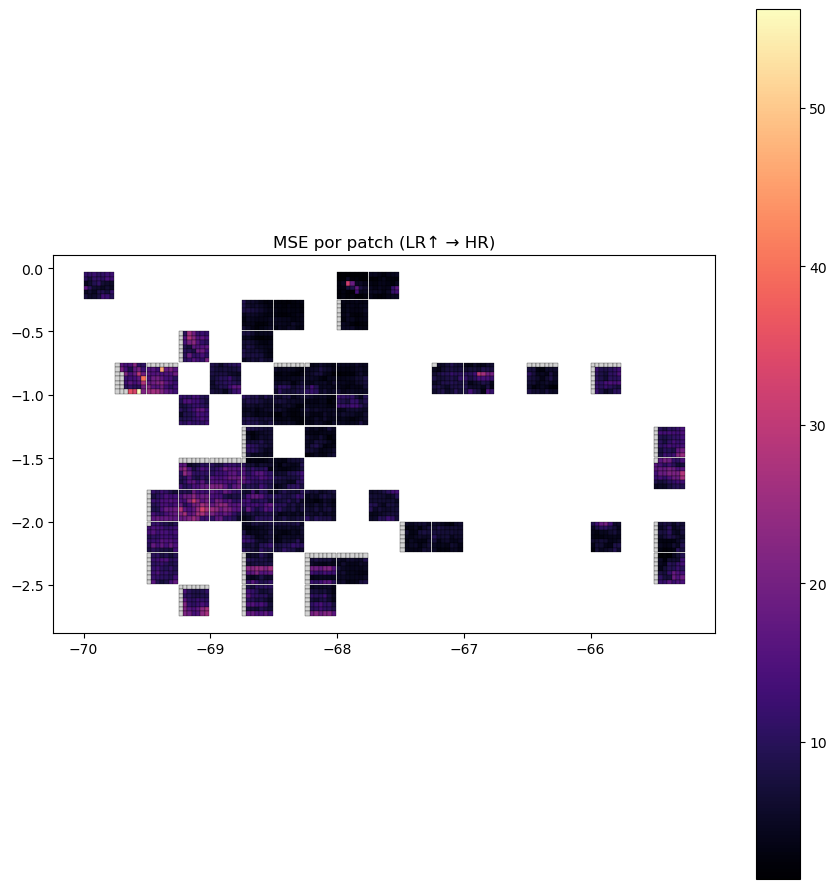

In [2]:
import torch
import torch.nn.functional as F
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np


def _to_bounds_tuple(bb) -> tuple[float, float, float, float]:
    """Aceita torchgeo BoundingBox, dict ou tupla e devolve (minx, miny, maxx, maxy)."""
    # torchgeo BoundingBox tem atributos: minx, miny, maxx, maxy
    if hasattr(bb, "minx"):
        return float(bb.minx), float(bb.miny), float(bb.maxx), float(bb.maxy)
    # dict com chaves
    if isinstance(bb, dict) and all(k in bb for k in ("minx", "miny", "maxx", "maxy")):
        return float(bb["minx"]), float(bb["miny"]), float(bb["maxx"]), float(bb["maxy"])
    # tupla/lista
    if isinstance(bb, (tuple, list)) and len(bb) >= 4:
        return float(bb[0]), float(bb[1]), float(bb[2]), float(bb[3])
    raise ValueError(f"Formato de bounds não suportado: {type(bb)}")


@torch.no_grad()
def gdf_mse_from_loader(
    loader,
    save_gpkg: str | None = None,
    layer_name: str = "mse_patches",
    cmap: str = "magma",
    figsize=(9, 9),
):
    """
    Itera sobre 'loader' (batch-> dict com 'lr','hr','bounds','crs'),
    interpola LR↑ para HR, computa MSE por amostra e retorna/plot GDF.

    Args:
        loader: DataLoader com sampler sobre seus tiles.
        save_gpkg: caminho para salvar (driver=GPKG). Se None, não salva.
        layer_name: nome da camada no GPKG.
        cmap: colormap para o plot.
    """
    records = []
    crs_seen = None

    for bidx, batch in enumerate(loader):
        # Ajuste estas chaves caso o seu collate use outros nomes
        lr = batch["lr"]   # Tensor [B, C(or 1), h, w]
        hr = batch["hr"]   # Tensor [B, C(or 1), H, W]
        # Sequence com len=B (ideal) ou único para o batch
        bounds_b = batch["bounds"]
        crs_b = batch.get("crs", None)
        if crs_seen is None:
            crs_seen = crs_b

        # Garante tensor float e no mesmo device
        device = hr.device
        lr = lr.to(device=device, dtype=torch.float32)
        hr = hr.to(device=device, dtype=torch.float32)

        # Interpola LR para o tamanho espacial de HR (por amostra é idêntico, pois usamos size)
        _, _, H, W = hr.shape
        lr_up = F.interpolate(
            lr, size=(H, W), mode="bilinear", align_corners=False)

        # MSE com máscara de valores finitos (evita contaminar com NaN/Inf)
        # Forma: [B, C, H, W] -> reduz para escalar por amostra
        finite_mask = torch.isfinite(lr_up) & torch.isfinite(hr)
        # Garante pelo menos um canal (se for [B, H, W], adicione dimensão)
        if lr_up.ndim == 3:
            lr_up = lr_up.unsqueeze(1)
        if hr.ndim == 3:
            hr = hr.unsqueeze(1)

        B = hr.shape[0]

        # Normaliza bounds_b para sequência por amostra
        if isinstance(bounds_b, (list, tuple)) and len(bounds_b) == B:
            bounds_seq = bounds_b
        else:
            # Se veio um único bounds para o batch, replica
            bounds_seq = [bounds_b] * B

        for j in range(B):
            # Máscara por amostra j
            m = finite_mask[j]
            if m.any():
                diff2 = (lr_up[j] - hr[j]) ** 2
                mse_j = diff2[m].mean().item()
            else:
                mse_j = float("nan")

            # Bounds -> polygon
            minx, miny, maxx, maxy = _to_bounds_tuple(bounds_seq[j])
            geom = box(minx, miny, maxx, maxy)

            records.append({"mse": mse_j, "geometry": geom})

    # Constrói GeoDataFrame
    gdf = gpd.GeoDataFrame(records, geometry="geometry", crs="EPSG:4326")

    # (Opcional) Salvar em GPKG
    if save_gpkg:
        # Se a camada já existir, sobrescreva:
        # gpd>=0.12 não tem 'if_exists' no to_file; para garantir, você pode remover a camada antes externamente.
        gdf.to_file(save_gpkg, layer=layer_name, driver="GPKG")

    # Plot
    ax = gdf.plot(
        column="mse",
        legend=True,
        figsize=figsize,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "sem dados"},
    )
    ax.set_title("MSE por patch (LR↑ → HR)")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

    return gdf


mse_gdf = gdf_mse_from_loader(loader=train_dataload)

18.697438049316407

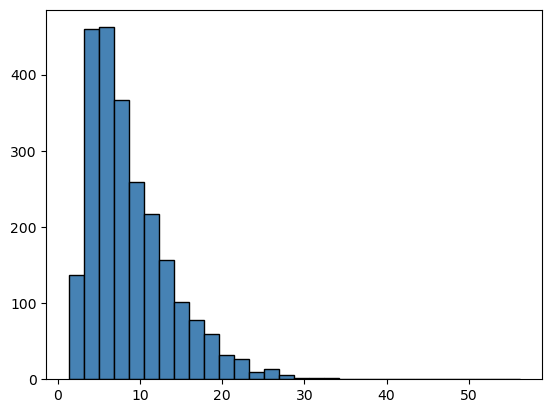

In [4]:
mse_values = np.array(mse_gdf.mse)
plt.hist(mse_values, bins=30, color="steelblue", edgecolor="black")

mse_values = mse_values[np.isfinite(mse_values)]
E95 = np.percentile(mse_values, 95)
E95

## plot normalização linear e logarítimica

In [2]:
import pandas as pd
import numpy as np
import torch
from torchgeo.datasets import RasterDataset, BoundingBox
from torchgeo_modules import DEMDataset  # Importando sua classe
import matplotlib.pyplot as plt
from typing import List, Optional


def rasterDs2pd(
    ds: RasterDataset,
    roi: Optional[BoundingBox] = None,
    nodata: Optional[float] = None,
    max_tiles: Optional[int] = None
) -> pd.DataFrame:
    """
    Extrai todos os valores de pixel válidos de um RasterDataset e os retorna
    em um DataFrame do Pandas.

    Args:
        ds: O RasterDataset de entrada (ex: uma instância de DEMDataset).
        roi: BoundingBox opcional para limitar a área de extração.
             Por padrão, utiliza a extensão total do dataset.
        nodata: Valor NoData opcional a ser filtrado.
        max_tiles: Número máximo opcional de tiles para processar (útil para testes).

    Returns:
        Um DataFrame do Pandas com uma única coluna "pixel_value" contendo
        todos os valores válidos do dataset.
    """
    roi = roi or ds.bounds
    idx = ds.index
    dim = getattr(idx.properties, "dimension", 2)

    # Monta a consulta para o índice espacial
    if dim == 3:
        query = (roi.minx, roi.miny, roi.maxx, roi.maxy, roi.mint, roi.maxt)
    else:
        query = (roi.minx, roi.miny, roi.maxx, roi.maxy)

    items = list(idx.intersection(query, objects=True))
    if not items:
        print("Aviso: Nenhum tile encontrado no ROI fornecido.")
        return pd.DataFrame({'pixel_value': []})

    all_values = []
    print(f"Processando {len(items) if max_tiles is None else max_tiles} tiles...")

    for i, it in enumerate(items):
        if max_tiles and i >= max_tiles:
            break

        # Extrai os dados do tile
        if dim == 3:
            minx, maxx, miny, maxy, mint, maxt = it.bounds
        else:
            minx, maxx, miny, maxy = it.bounds
            mint, maxt = ds.bbox.mint, ds.bbox.maxt

        tile_bb = BoundingBox(minx, maxx, miny, maxy, mint, maxt)
        
        try:
            sample = ds[tile_bb]
            tensor = sample['image'].to(torch.float32)

            # Filtra valores inválidos
            valid_mask = torch.isfinite(tensor)
            if nodata is not None:
                valid_mask &= (tensor != nodata)

            # Adiciona valores válidos à lista
            valid_pixels = tensor[valid_mask].numpy()
            if valid_pixels.size > 0:
                all_values.append(valid_pixels)
        except Exception as e:
            print(f"Erro ao processar o tile {i}: {e}")
            continue

    if not all_values:
        print("Aviso: Nenhum valor de pixel válido foi encontrado.")
        return pd.DataFrame({'pixel_value': []})

    # Concatena todos os arrays de valores e cria o DataFrame
    final_values = np.concatenate(all_values)
    df = pd.DataFrame(final_values, columns=['pixel_value'])
    print("Processamento concluído.")
    return df

In [3]:
input_df_train = rasterDs2pd(input_train)
input_df_val = rasterDs2pd(input_val)
input_df_test = rasterDs2pd(input_test)

ram_df_train = rasterDs2pd(ram_train)
ram_df_val = rasterDs2pd(ram_val)
ram_df_test = rasterDs2pd(ram_test)

Processando 53 tiles...
Processamento concluído.
Processando 17 tiles...
Processamento concluído.
Processando 17 tiles...
Processamento concluído.
Processando 53 tiles...
Processamento concluído.
Processando 17 tiles...
Processamento concluído.
Processando 17 tiles...
Processamento concluído.


In [4]:
def log_normalizer(df:pd.DataFrame, max: float, min:float):
    df['log_normal'] = np.log(np.clip(df['pixel_value']-min , a_min=1e-6,a_max=2000))/np.log(max - min)    
    return  df

input_max, input_min = input_df_train['pixel_value'].max(), input_df_train['pixel_value'].min()
input_df_train = log_normalizer(input_df_train, input_max, input_min  )
input_df_val = log_normalizer(input_df_val, input_max, input_min  )
input_df_test = log_normalizer(input_df_test, input_max, input_min )

ram_max, ram_min = ram_df_train['pixel_value'].max(),ram_df_train['pixel_value'].min()
ram_df_train = log_normalizer(ram_df_train, ram_max, ram_min )
ram_df_val = log_normalizer(ram_df_val, ram_max, ram_min)
ram_df_test = log_normalizer(ram_df_test, ram_max, ram_min)

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 6), sharex='all', sharey='all')
input_df_train['pixel_value'].hist(bins=100, label = 'train', ax=axs[0,0],density=True, facecolor='skyblue', )
input_df_val['pixel_value'].hist(bins=100, label = 'val',ax=axs[1,0], density=True, facecolor='green')
input_df_test['pixel_value'].hist(bins=100,label = 'test', ax=axs[2,0],density=True, facecolor='red')
axs[0,0].set_title('Dataset COP')
axs[2,0].set_xlabel('elevação')
axs[0,0].set_ylabel('treino')
axs[1,0].set_ylabel('val')
axs[2,0].set_ylabel('teste')

ram_df_train['pixel_value'].hist(bins=100, label = 'train', ax=axs[0,1],density=True, facecolor='skyblue', )
ram_df_val['pixel_value'].hist(bins=100, label = 'val',ax=axs[1,1], density=True, facecolor='green')
ram_df_test['pixel_value'].hist(bins=100,label = 'test', ax=axs[2,1],density=True, facecolor='red')
axs[0,1].set_title('Dataset RAM')
axs[2,1].set_xlabel('elevação')


plt.show()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 6), sharex='all', sharey='all')
input_df_train['log_normal'].hist(bins=100, label = 'train', ax=axs[0,0],density=True, facecolor='skyblue', )
input_df_val['log_normal'].hist(bins=100, label = 'val',ax=axs[1,0], density=True, facecolor='green')
input_df_test['log_normal'].hist(bins=100,label = 'test', ax=axs[2,0],density=True, facecolor='red')
axs[0,0].set_title('Dataset COP')
axs[2,0].set_xlabel('log(elevação)')
axs[0,0].set_ylabel('treino')
axs[1,0].set_ylabel('val')
axs[2,0].set_ylabel('teste')

ram_df_train['log_normal'].hist(bins=100, label = 'train', ax=axs[0,1],density=True, facecolor='skyblue', )
ram_df_val['log_normal'].hist(bins=100, label = 'val',ax=axs[1,1], density=True, facecolor='green')
ram_df_test['log_normal'].hist(bins=100,label = 'test', ax=axs[2,1],density=True, facecolor='red')
axs[0,1].set_title('Dataset RAM')
axs[2,1].set_xlabel('log(elevação)')


plt.show()

In [ ]:
def linear_normalizer(df:pd.DataFrame, max: float, min:float):
    df['linear_normal'] = (df['pixel_value']-min )/(max - min)  
    return  df

def z_score(df:pd.DataFrame, mean: float, std:float):
    df['z_score'] = (df['linear_normal']- mean)/std
    return  df
input_max, input_min = input_df_train['pixel_value'].max(), input_df_train['pixel_value'].min()

input_df_train = linear_normalizer(input_df_train, input_max, input_min )
input_df_val = linear_normalizer(input_df_val, input_max, input_min  )
input_df_test = linear_normalizer(input_df_test, input_max, input_min )

mean = 0.0854 ; std=0.0355
input_df_train = z_score(input_df_train,  mean, std )
input_df_val = z_score(input_df_val, mean, std  )
input_df_test = z_score(input_df_test, mean, std )


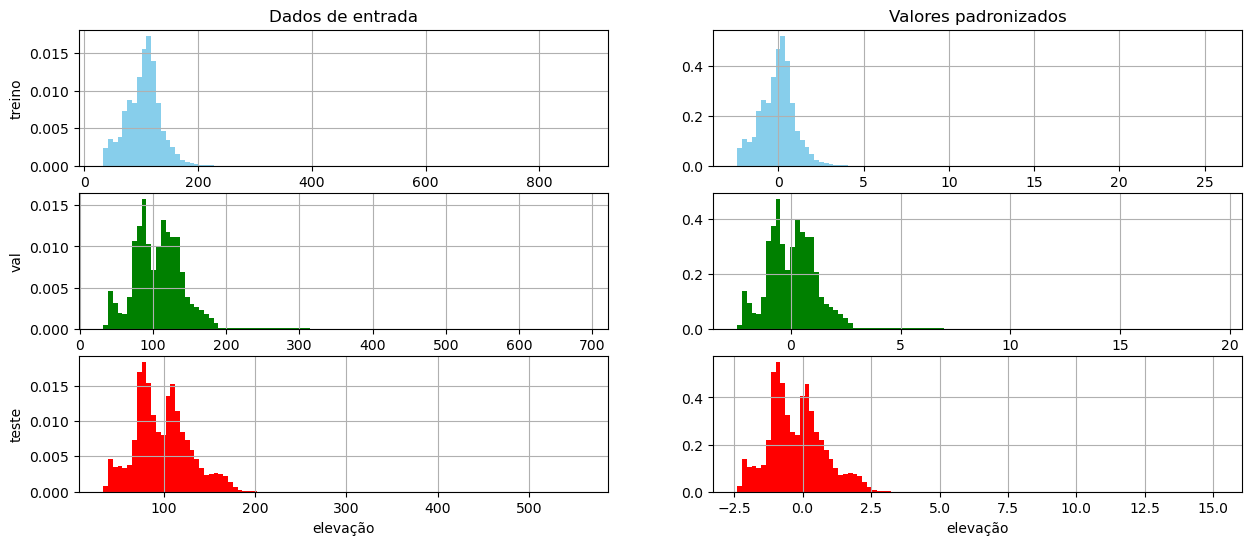

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 6))
input_df_train['pixel_value'].hist(bins=100, label = 'train', ax=axs[0,0],density=True, facecolor='skyblue', )
input_df_val['pixel_value'].hist(bins=100, label = 'val',ax=axs[1,0], density=True, facecolor='green')
input_df_test['pixel_value'].hist(bins=100,label = 'test', ax=axs[2,0],density=True, facecolor='red')
axs[0,0].set_title('Dados de entrada')
axs[2,0].set_xlabel('elevação')
axs[0,0].set_ylabel('treino')
axs[1,0].set_ylabel('val')
axs[2,0].set_ylabel('teste')

input_df_train['z_score'].hist(bins=100, label = 'train', ax=axs[0,1],density=True, facecolor='skyblue', )
input_df_val['z_score'].hist(bins=100, label = 'val',ax=axs[1,1], density=True, facecolor='green')
input_df_test['z_score'].hist(bins=100,label = 'test', ax=axs[2,1],density=True, facecolor='red')
axs[0,1].set_title('Valores padronizados')
axs[2,1].set_xlabel('elevação')


plt.show()

## raster2pcd

Número de pontos válidos na nuvem: 13769383


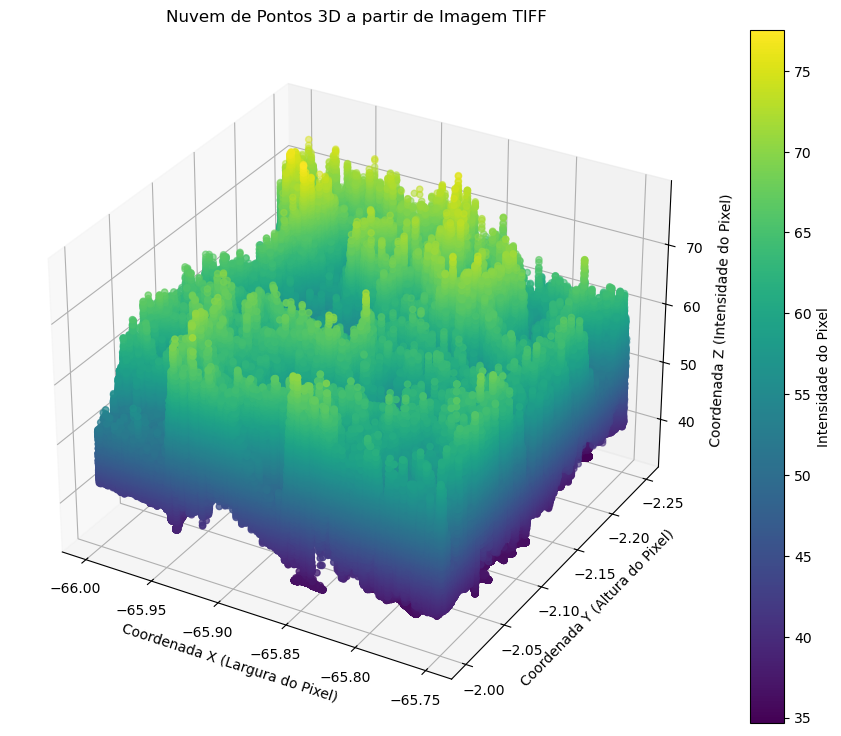

In [3]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

tif_path = r"C:\Users\Eduardo JR\Fast\SRIU\zoom_4\train\ram_0452-1_dsm.tif"

# with Image.open(tif_path) as img:
#             # Converte a imagem para uma matriz NumPy para manipulação numérica.
#             matriz_pixels = np.array(img)

with rio.open(tif_path) as ds:
    array = ds.read(1)
    transform = ds.transform
    crs = ds.crs
    bbox = ds.bounds            
altura, largura = array.shape
array[array==-9999] = float('nan')
xmin, xmax, ymin, ymax = bbox.left, bbox.right, bbox.bottom, bbox.top

x_coords = np.arange(start=xmin, stop=xmax, step=((xmax-xmin)/largura))
y_coords = np.arange(start=ymin, stop=ymax, step=((ymax-ymin)/largura))
x,y = np.meshgrid(x_coords, y_coords)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = array.flatten()

mask = ~np.isnan(z_flat)
x_clean = x_flat[mask]
y_clean = y_flat[mask]
z_clean = z_flat[mask]

points_xyz = np.vstack((x_clean, y_clean, z_clean)).T
print(f"Número de pontos válidos na nuvem: {len(points_xyz)}")

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_clean, y_clean, z_clean, 
                     c=z_clean, cmap='viridis')
ax.set_title('Nuvem de Pontos 3D a partir de Imagem TIFF')
ax.set_xlabel('Coordenada X (Largura do Pixel)')
ax.set_ylabel('Coordenada Y (Altura do Pixel)')
ax.set_zlabel('Coordenada Z (Intensidade do Pixel)')
ax.invert_yaxis()
fig.colorbar(scatter, ax=ax, label='Intensidade do Pixel')
plt.show()